In [1]:
## Imports
import time
import webbrowser
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import pickle

import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'g'

import time_series_functions as tsf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', category=UserWarning)

from prophet import Prophet

from sklearn.metrics import mean_squared_error, r2_score

plt.figure(figsize=(8, 16), dpi=80)

<Figure size 640x1280 with 0 Axes>

<Figure size 640x1280 with 0 Axes>

In [2]:
##Functions        
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=200, freq='M'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    count=0
    for comb in pdq:
        for combs in pdqs:
            try:
                count+=1
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(disp=False,maxiter=maxiter,method_kwargs={"warn_convergence": False}) 
                ans.append([comb, combs, output.bic])
                #print('SARIMAX {} x {} : BIC Calculated ={}'.format(comb, combs, output.bic))
                if count%300==0:
                    print(count)
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
    ans_df=ans_df[~ans_df.duplicated(keep='first')]

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    ans_df=ans_df.reset_index(drop=True)
    
    return ans_df

def calculate_adfuller(time_series):
    result = adfuller(time_series.dropna(),autolag='AIC')
    return result[1]

def calculate_d(train):
    
    d=0
    p_value=1
    while d<4:
    
    
        p_value=tsf.calculate_adfuller(train)
        if p_value<=0.05:
            return d
        else:
            d+=1
            train=train.diff()
    return d
def calculate_p_q(time_series,d,D,freq):
    
    p=q=range(0,3)
    to_perm=list(p)+list(q)
    permutations=[list(x) for x in itertools.permutations(to_perm,2)]
    pdq=[x.insert(1,d) or x for x in permutations]
    pdq=[tuple(x) for x in pdq]
    seasonal_pdq = [(x[0], D, x[2], seasonality) for x in pdq]
    ##Determining best parameters
    outcome=sarimax_gridsearch(time_series, pdq, seasonal_pdq,freq=freq)
    
    return outcome

def pickle_model(pdq,pdqs, model, period):
    
    file = open('best_parameters.pkl', 'rb')
    best_parameters = pickle.load(file)
    file.close()
    best_parameters[period]=[(pdq),(pdqs),model]
    # open a file, where you ant to store the data
    file = open('best_parameters.pkl', 'wb')

    # dump information to that file
    pickle.dump(best_parameters, file)

    print('Pickled!!!')

def printing_ci():

    fig=ts_test.plot(label='Observed',alpha=0.7,figsize=(14,10))
    #ts_test.plot(figsize=(16,8))
    fig.set_xlabel(period)
    fig.set_ylabel('Energy Consumption')
    fig.fill_between(ci.index,
                    ci.iloc[:,0],
                    ci.iloc[:,1],color='k',alpha=.2)
    plt.legend();

In [3]:
##Loading gthe datset and cleaning dups
df=pd.read_csv('../AEP_hourly.csv')
#print(df.dtypes,df.shape)
df=df.groupby('Datetime').AEP_MW.mean()
df=df.reset_index()

#creating the time series
df['Datetime']=pd.to_datetime(df['Datetime'])
new_df=df.set_index(['Datetime'])

new_df.sort_index(inplace=True)
##Creating full calendar
start=new_df.index[0]
end=new_df.index[-1]
full_calendar=pd.date_range(start, end,freq='H')
##Putting it all together
calendar=pd.DataFrame(full_calendar,columns=['Datetime']).set_index('Datetime')#,new_df.head()
final_df=calendar.join(new_df)
print(final_df.isnull().sum())
final_df=final_df.interpolate()
final_df.head()
print(final_df.isnull().sum())
hourly_df=final_df[['AEP_MW']].asfreq('H').copy()
daily_df=final_df[['AEP_MW']].resample('D').sum()[:-1]
weekly_df=final_df[['AEP_MW']].resample('W').sum()[1:-1]
monthly_df=final_df[['AEP_MW']].resample('M').sum()[3:-1]
quarterly_df=final_df[['AEP_MW']].resample('Q').sum()[1:-1]

AEP_MW    27
dtype: int64
AEP_MW    0
dtype: int64


# Time Series Analysis. Frequency:<a id='start'></a>
[1. Quarterly.](#quarterly)<br>
[2. Monthly.](#monthly)<br>
[3. Weekly.](#weekly)<br>
[4. Daily.](#daily)<br>
[5. Hourly.](#hourly)

<a id='quarterly'></a>
# Quarterly
[Back top](#start)

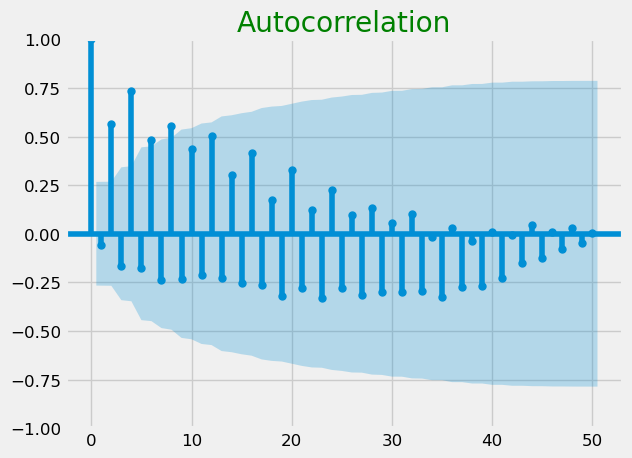

<Figure size 3000x1500 with 0 Axes>

In [4]:
##Determining seasonality
plot_acf(quarterly_df, lags=50)
plt.figure(figsize = (30, 15))
plt.show()

This is my d:  1
This is my D:  0
300
600
900
Pickled!!!
                                     SARIMAX Results                                     
Dep. Variable:                            AEP_MW   No. Observations:                   48
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 4)   Log Likelihood                -560.122
Date:                           Tue, 11 Jun 2024   AIC                           1134.244
Time:                                   14:50:42   BIC                           1145.328
Sample:                               03-31-2005   HQIC                          1138.112
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0830      0.434     -0.191      0.848      -0.93

True

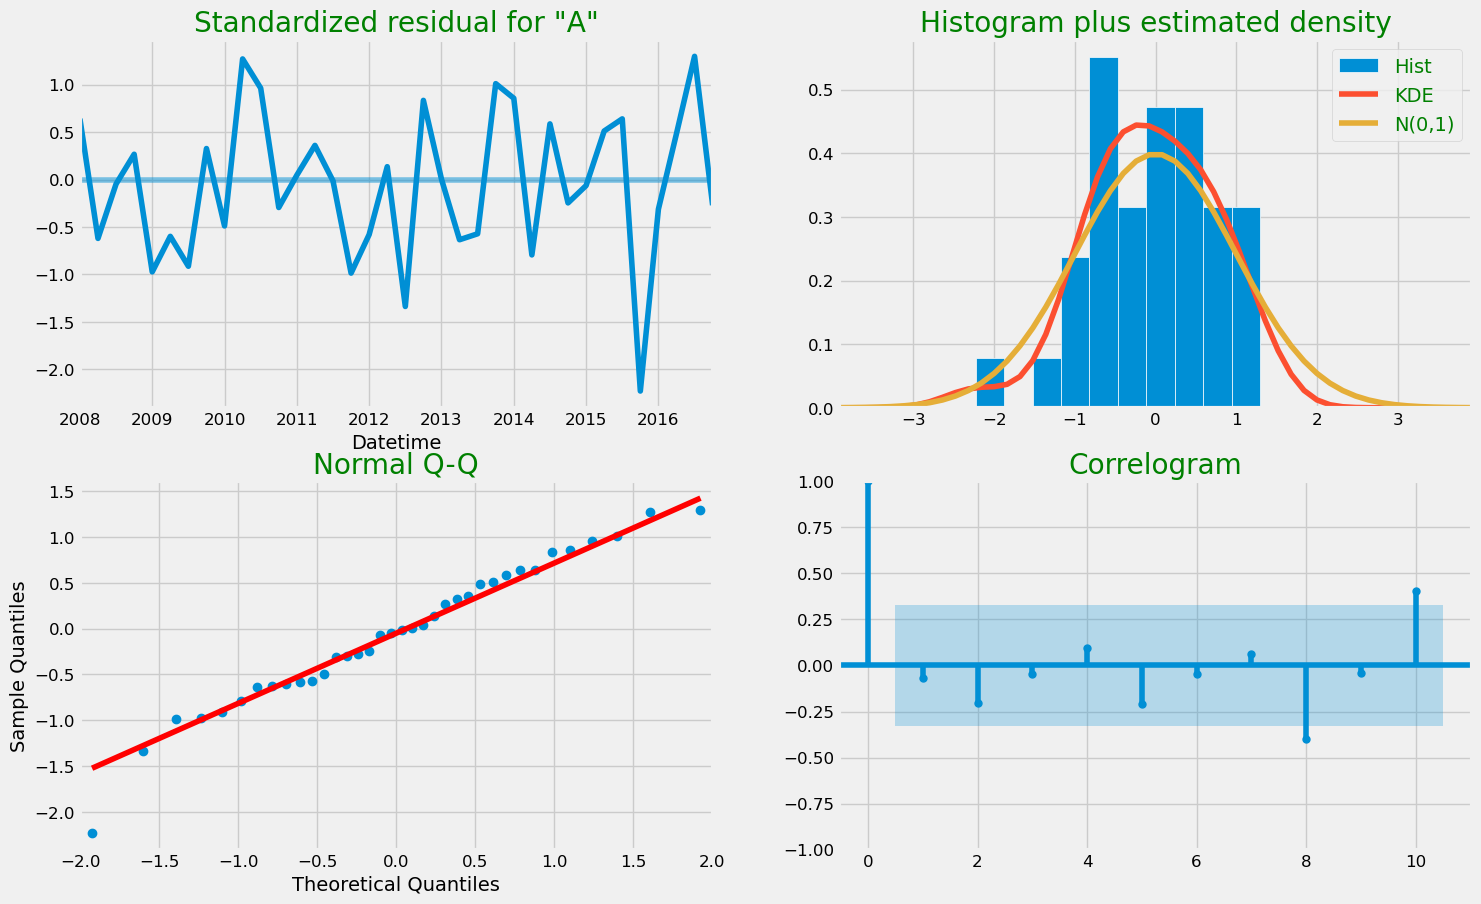

In [5]:
#TimeSeries
ts=quarterly_df.loc['2005':'2018'].copy()
seasonality=4
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='Q'
maxiter=300
period='quarterly'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)

# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

NRMSE:  0.4135920710761675


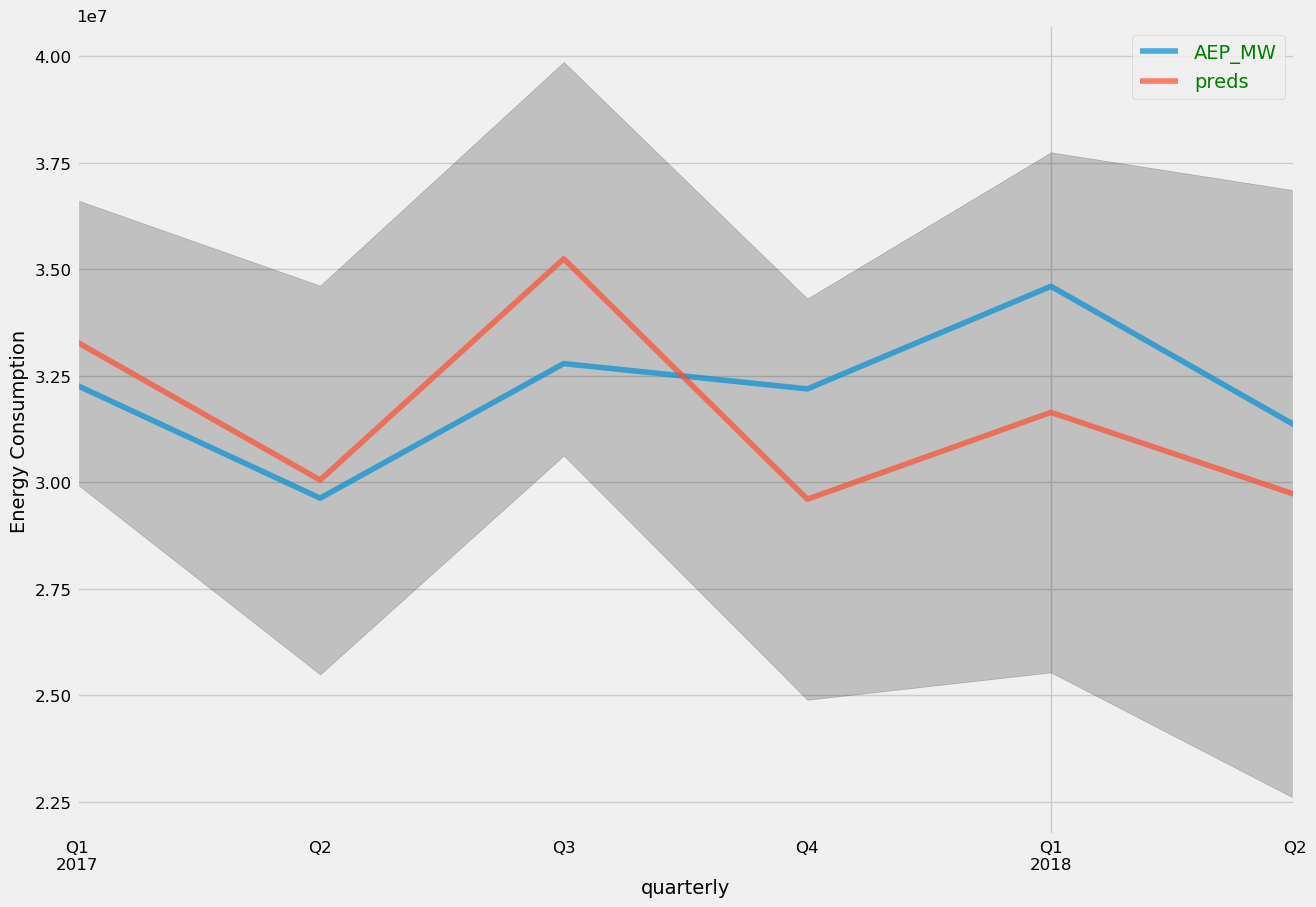

In [8]:
##TimeSeries
ts=quarterly_df.loc['2005':'2018'].copy()
seasonality=4
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='Q'
maxiter=300
period='quarterly'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]
model_q=best_parameters[period][2]


forecast=model_q.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
predictions=forecast.predicted_mean
ts_test['preds']=predictions

sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions)),2)
sarimax_nrmse=sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW))
print("NRMSE: ",sarimax_nrmse,)

printing_ci()


14:51:17 - cmdstanpy - INFO - Chain [1] start processing
14:51:18 - cmdstanpy - INFO - Chain [1] done processing


NRMSE:  0.27


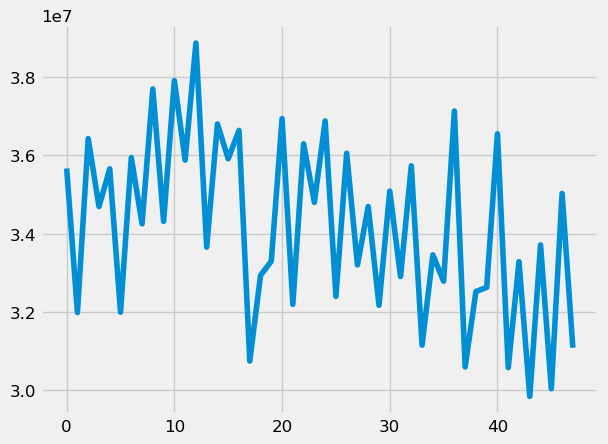

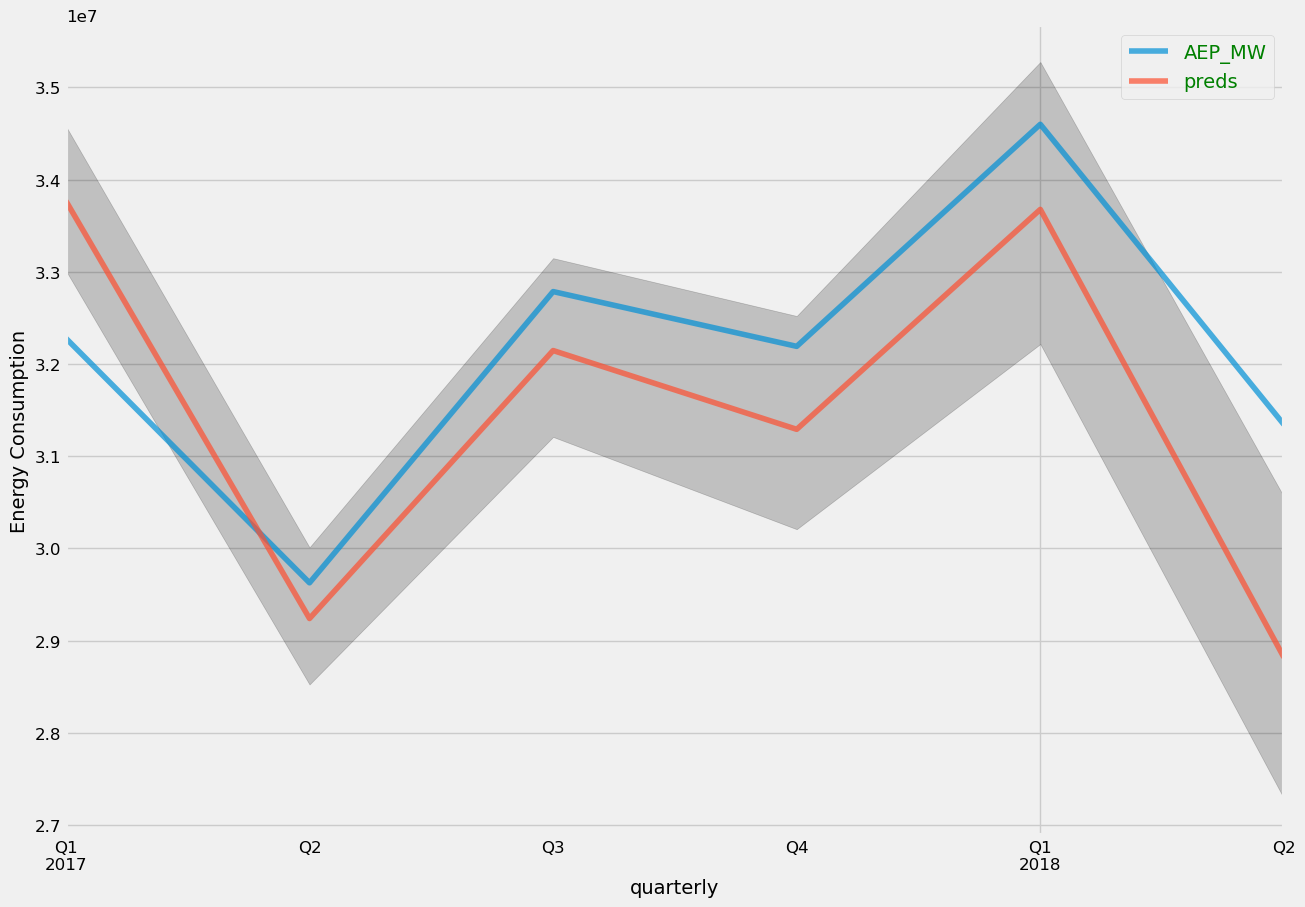

In [9]:
#Prophet
ts=quarterly_df.loc['2005':'2018'].copy()
seasonality=4
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='Q'

####Prepping for Prophet
ts_train=ts_train.reset_index()

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train,)
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]

ts_test['preds']=predictions
# ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.preds))
prophet_nrmse=round(prophet_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",prophet_nrmse)
printing_ci()

# And the winner is

In [10]:
if round(sarimax_nrmse-prophet_nrmse,2) >0:
    print('Prophet WINS')
elif round(sarimax_nrmse-prophet_nrmse,2) <0:
    print('SARIMAX WINS')
else:
    print('It is a tie')


Prophet WINS


<a id='monthly'></a>
# Monthly Analysis
[Back top](#start)

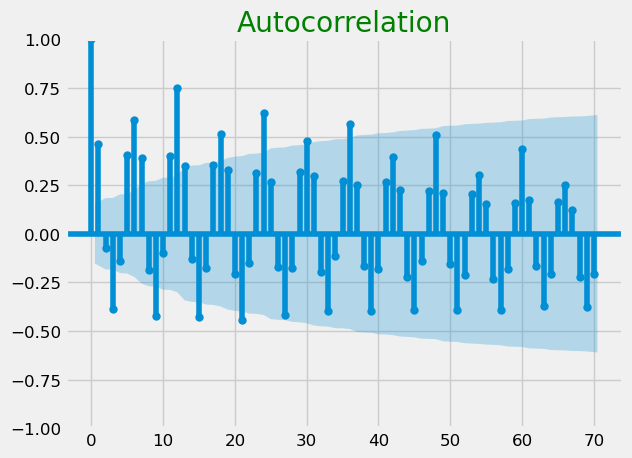

In [11]:
##Determining seasonality
plot_acf(monthly_df, lags=70)
plt.show()

In [ ]:

##TimeSeries
ts=monthly_df.loc['2008':'2018'].copy()
seasonality=12
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='M'
maxiter=100
period='monthly'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)

# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

NRMSE:  0.25


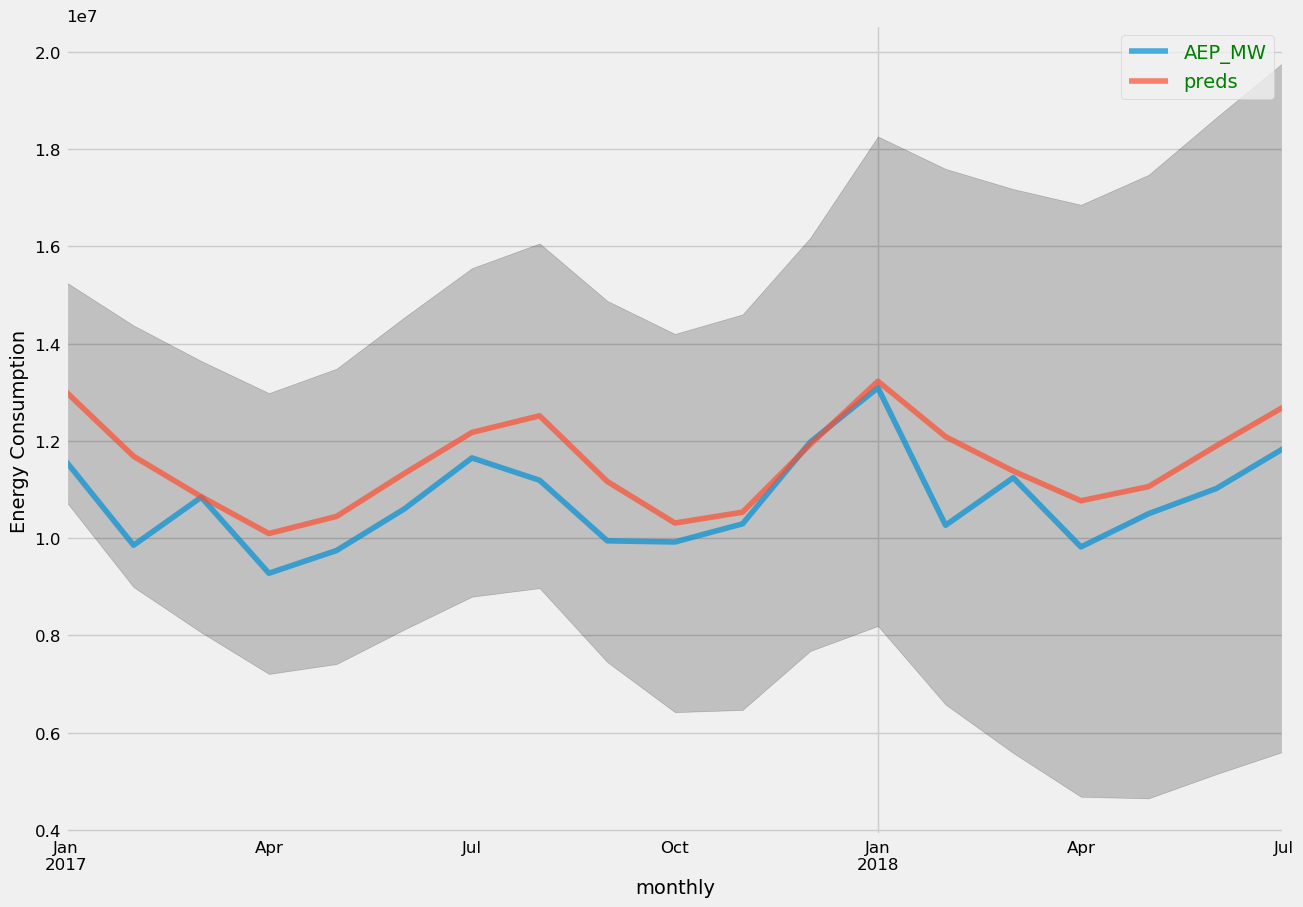

In [12]:
##TimeSeries
ts=monthly_df.loc['2005':'2018'].copy()
seasonality=12
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='M'
maxiter=100
period='monthly'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]
model_m=best_parameters[period][2]

forecast=model_m.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
predictions=forecast.predicted_mean
ts_test['preds']=predictions
sarimax_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions))
sarimax_nrmse= round(sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",sarimax_nrmse,)

printing_ci()

14:55:31 - cmdstanpy - INFO - Chain [1] start processing
14:55:31 - cmdstanpy - INFO - Chain [1] done processing


NRMSE:  0.15


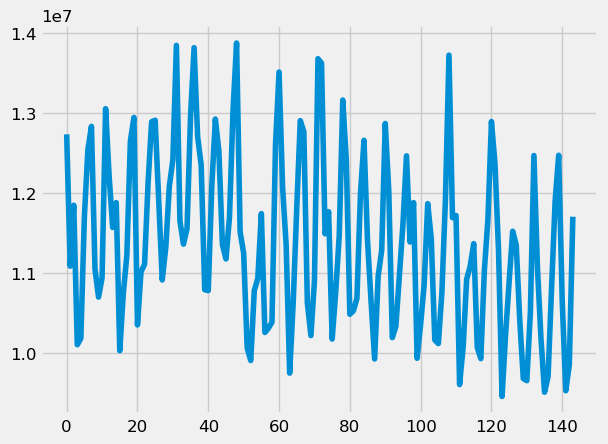

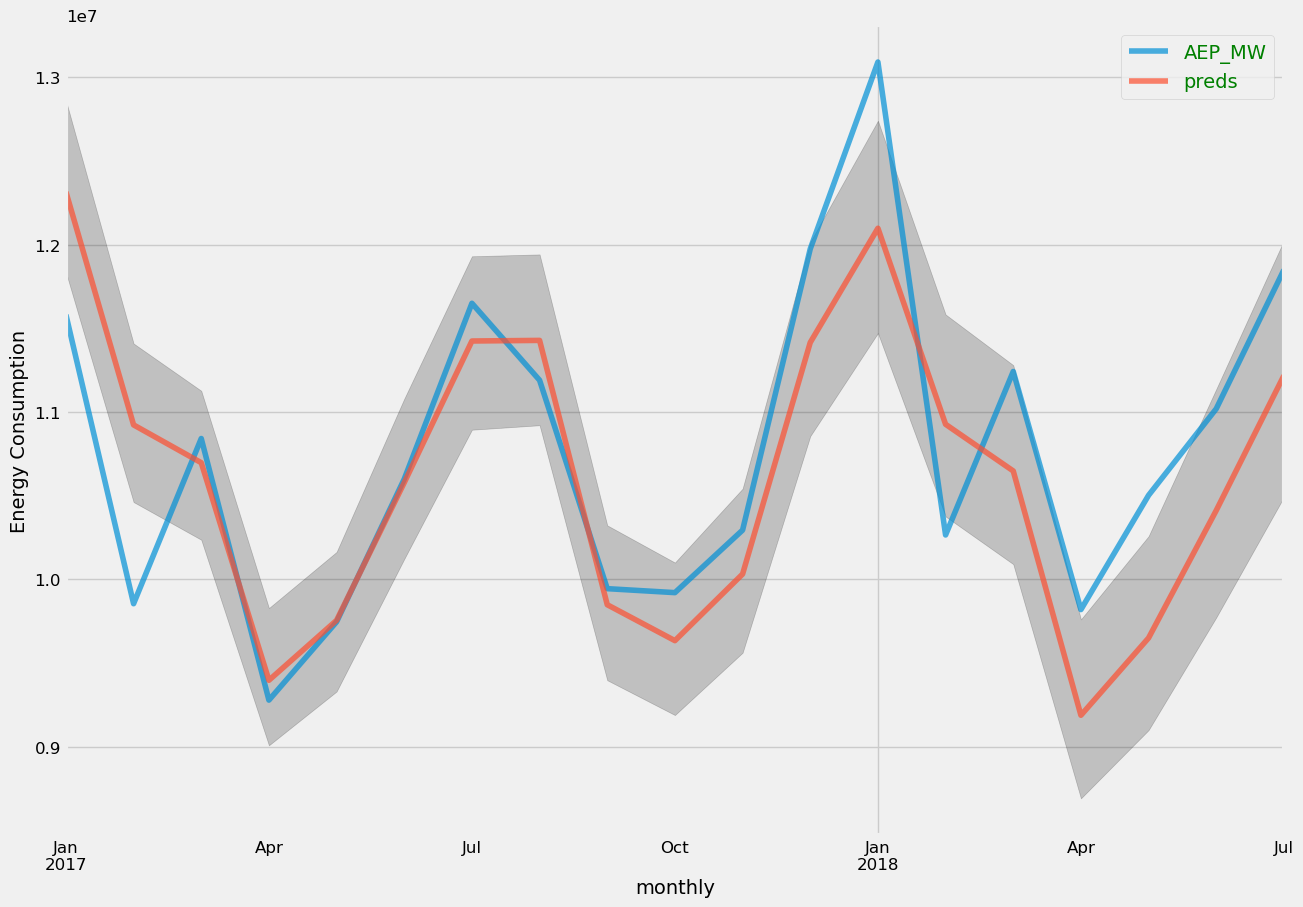

In [13]:
#Prophet
ts=monthly_df.loc['2005':'2018'].copy()
seasonality=12
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='M'
####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
future = model.make_future_dataframe(periods=periods_to_test, freq = 'M')
forecast = model.predict(future)
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]


ts_test['preds']=predictions
# ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.preds))
prophet_nrmse=round(prophet_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",prophet_nrmse)
printing_ci()

# And the winner is

In [14]:
if round(sarimax_rmse-prophet_rmse,2) >0:
    print('Prophet WINS')
elif round(sarimax_rmse-prophet_rmse,2) <0:
    print('Sarimax WINS')
else:
    print('It is a tie')


Prophet WINS


<a id='weekly'></a>
# Weekly Analysis
[Back top](#start)

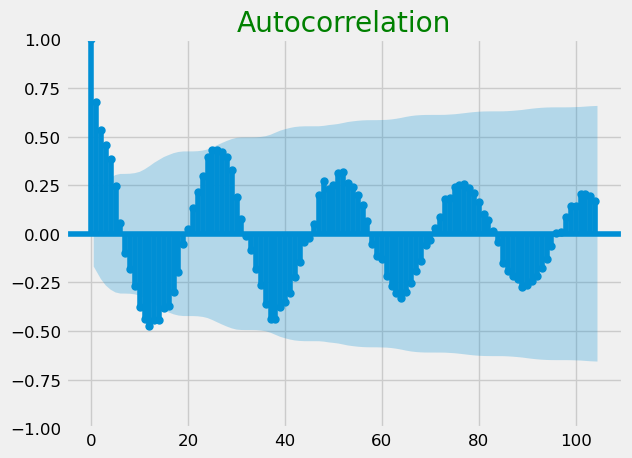

In [15]:
##Determining seasonality
plot_acf(weekly_df.loc['2016':'2018'], lags=104)
plt.show()

In [ ]:
##TimeSeries
ts=weekly_df.loc['2014':'2018'].copy()
seasonality=26
freq='W'

ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2014':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=200
period='weekly'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

NRMSE:  0.17


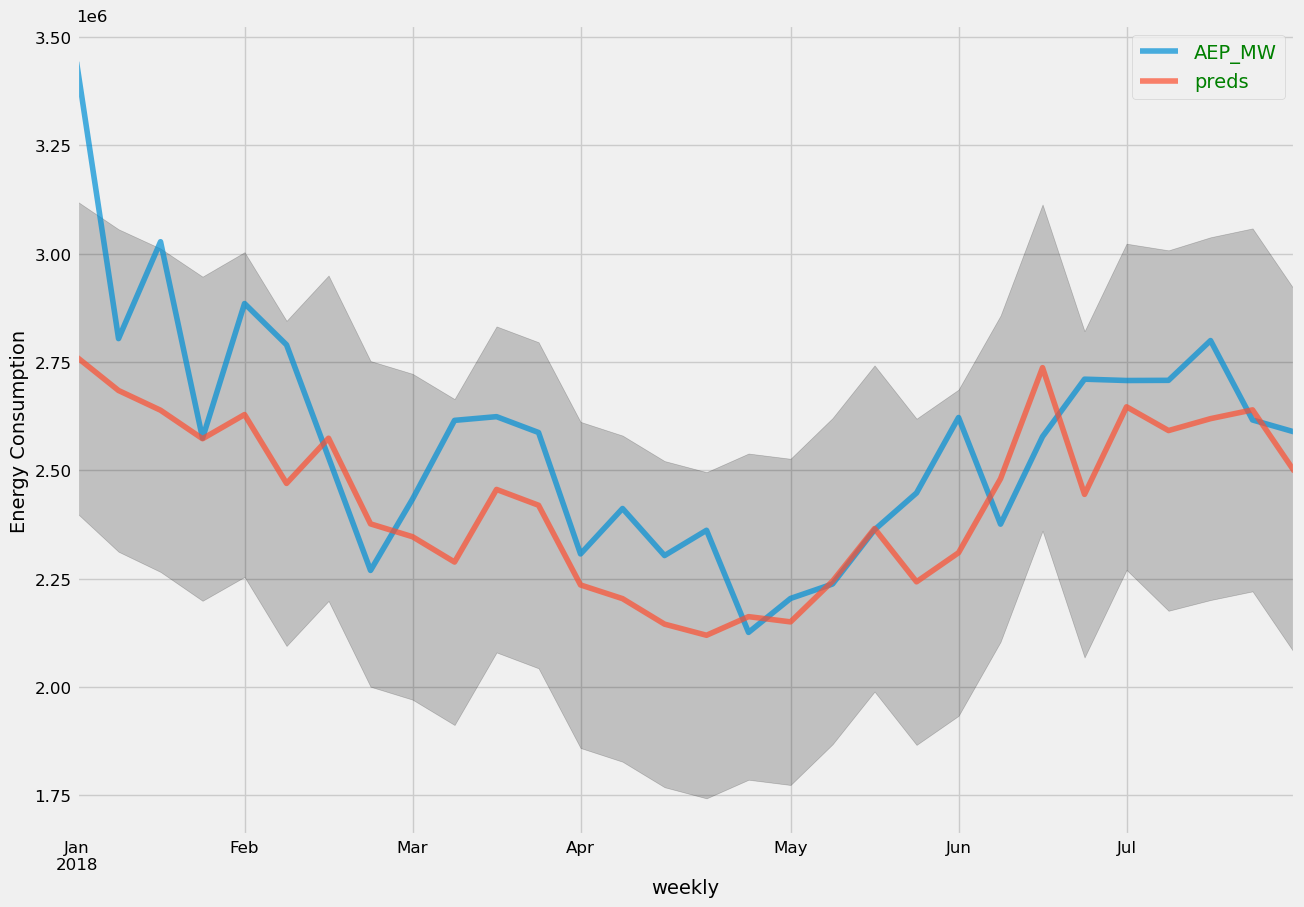

In [16]:
##TimeSeries
ts=s=weekly_df.loc['2015':'2018'].copy()
seasonality=26
freq='W'
ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2015':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=300
period='weekly'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]
model_w = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq).fit(disp=False,maxiter=maxiter,)

forecast=model_w.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
predictions=forecast.predicted_mean
ts_test['preds']=predictions
sarimax_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions))
sarimax_nrmse= round(sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",sarimax_nrmse,)

printing_ci()

14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing


NRMSE:  0.17


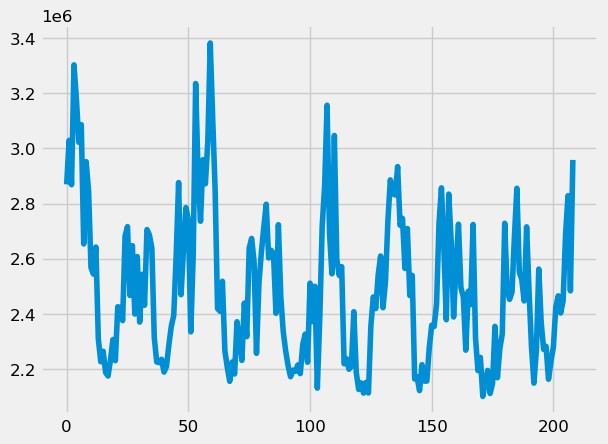

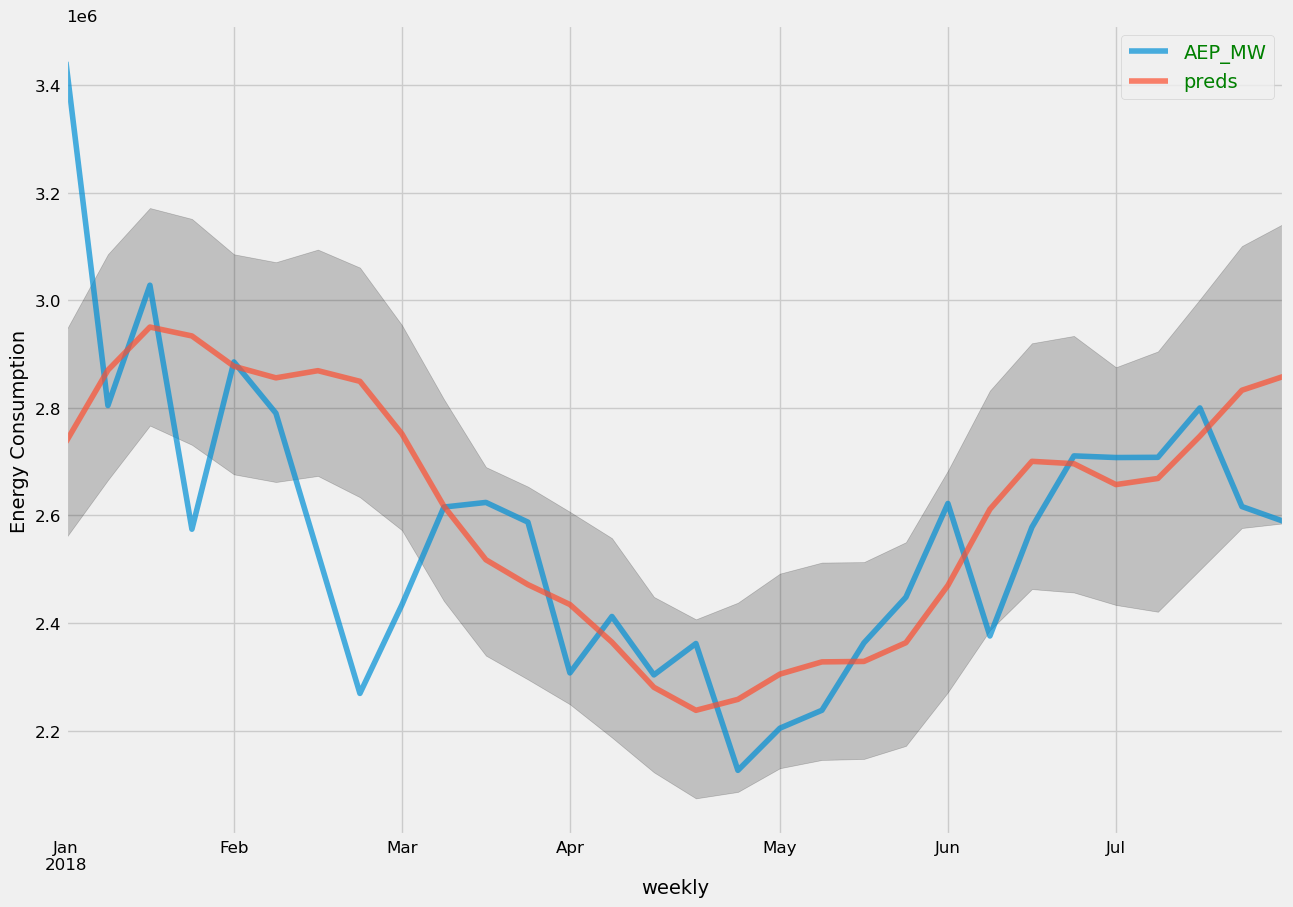

In [19]:
#Prophet
ts=weekly_df.loc['2014':'2018'].copy()
seasonality=26
ts_train=ts.loc['2014':'2017'].copy()
ts_test=ts.loc['2018'].copy()
periods_to_test=ts_test.shape[0]
freq='W'
####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
####Prepping for Prophet
ts_train=ts_train.reset_index()
future = model.make_future_dataframe(periods=periods_to_test, freq = 'W')
forecast = model.predict(future)
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
# ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.preds))
prophet_nrmse=round(prophet_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",prophet_nrmse)
printing_ci()

In [20]:
if round(sarimax_nrmse-prophet_nrmse,2) <0:
    print('Sarimax WINS')
elif round(sarimax_nrmse-prophet_nrmse,2) >0:
    print('Prophet WINS')
else:
    print('It is a tie')


It is a tie


<a id='daily'></a>
# Daily Analysis
[Back top](#start)

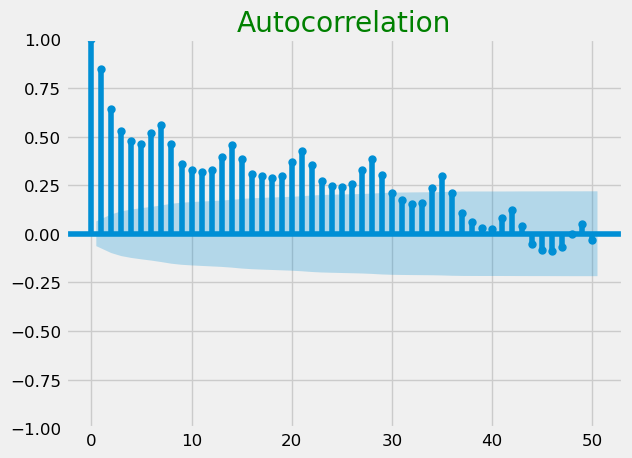

In [21]:
##Determining seasonality
plot_acf(daily_df.loc['2016':'2018'], lags=50)
plt.show()

In [ ]:
##TimeSeries
ts=daily_df.loc['2015':'2018'].copy()
seasonality=7
freq='D'

ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2015':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=200
period='daily_medium'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

NRMSE:  0.18


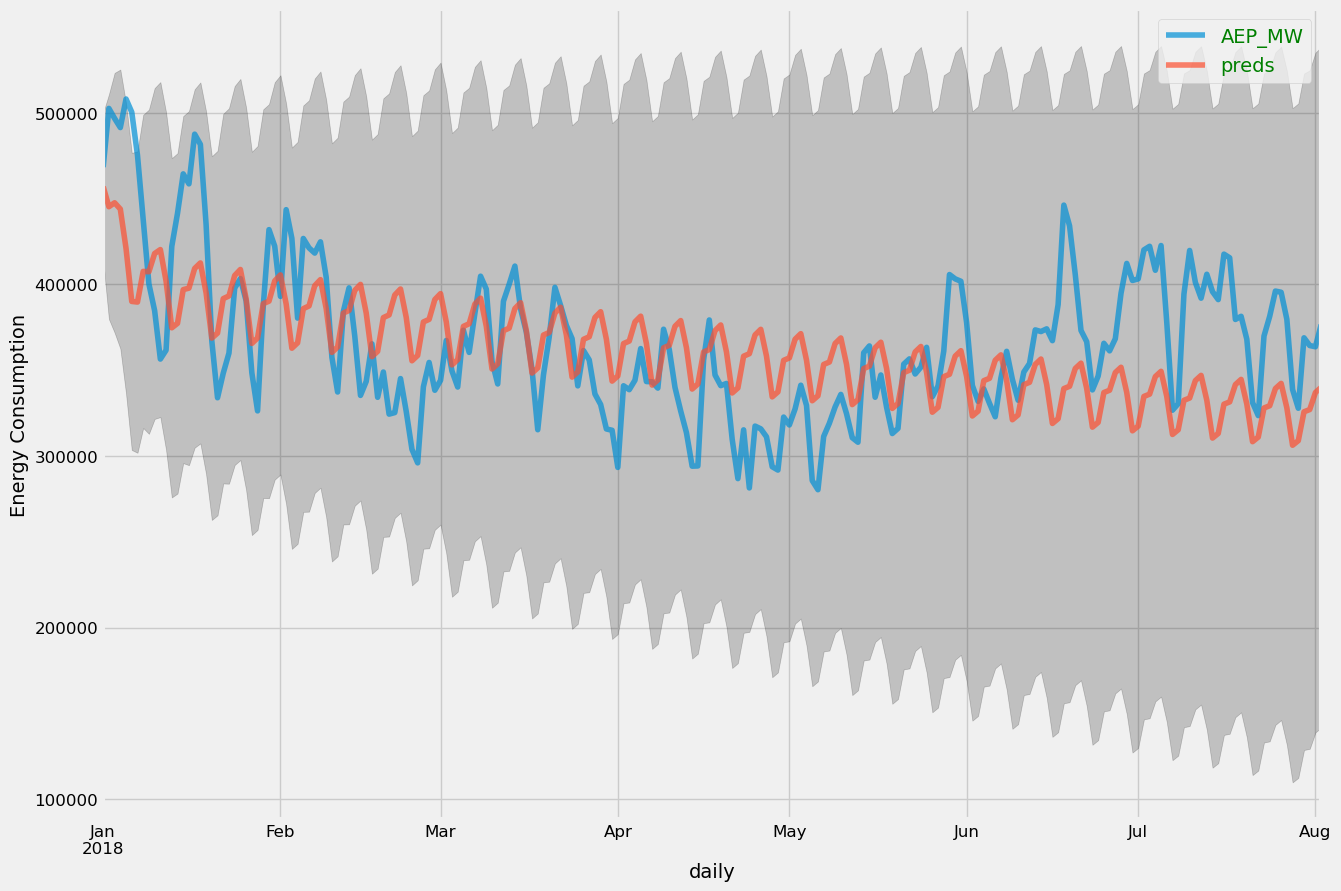

In [22]:
##TimeSeries
ts=daily_df.loc['2015':'2018'].copy()
seasonality=7
freq='D'
ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2015':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=300
period='daily'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]
model_d = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq).fit(disp=False,maxiter=maxiter,)

forecast=model_d.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
predictions=forecast.predicted_mean
ts_test['preds']=predictions
sarimax_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions))
sarimax_nrmse= round(sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",sarimax_nrmse,)

printing_ci()

15:01:27 - cmdstanpy - INFO - Chain [1] start processing
15:01:28 - cmdstanpy - INFO - Chain [1] done processing


NRMSE:  0.16


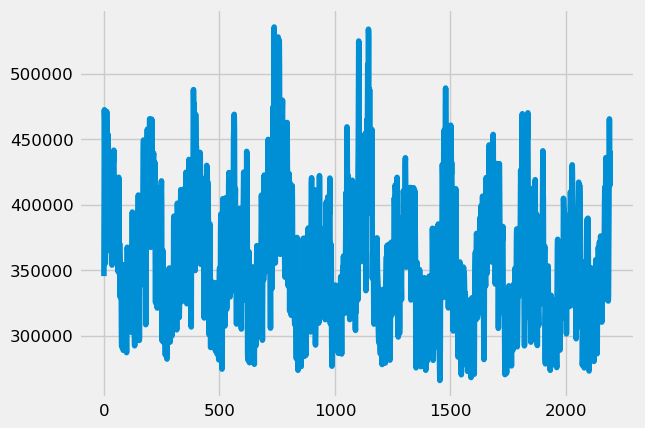

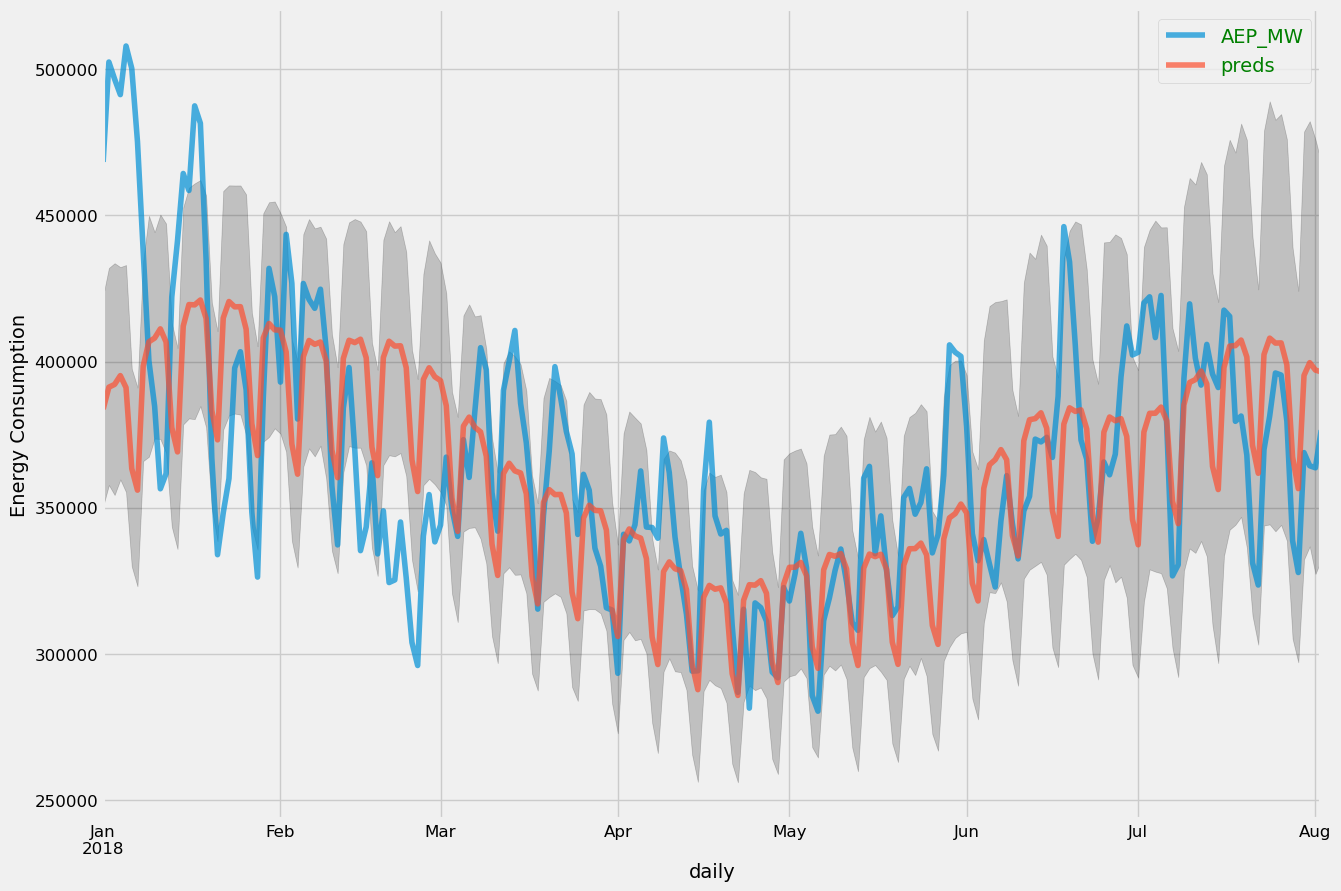

In [23]:
#Prophet
ts=daily_df.loc['2012':'2018'].copy()
seasonality=7
ts_train=ts.loc['2012':'2017'].copy()
ts_test=ts.loc['2018'].copy()
periods_to_test=ts_test.shape[0]
freq='D'
####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
future = model.make_future_dataframe(periods=periods_to_test, freq = 'D')
forecast = model.predict(future)
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
# ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.preds))
prophet_nrmse=round(prophet_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",prophet_nrmse)
printing_ci()

In [24]:
if round(sarimax_rmse-prophet_rmse,2) <0:
    print('Sarimax WINS')
elif round(sarimax_rmse-prophet_rmse,2) >0:
    print('Prophet WINS')
else:
    print('It is a tie')


Prophet WINS


<a id='hourly'></a>
# Hourly Analysis
[Back top](#start)

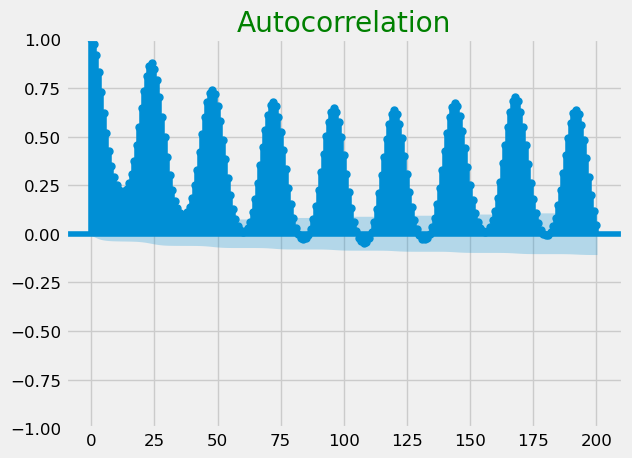

In [25]:
##Determining seasonality
plot_acf(hourly_df.loc['2016':'2018'], lags=200)
plt.show()

In [ ]:
##TimeSeries
ts=hourly_df[-600:].copy()
seasonality=24
freq='H'
ts_test=ts[-72:].copy()
ts_train=ts[:-72].copy()
# ts_test=ts[-int(ts.shape[0]*0.2):].copy()
# ts_train=ts[:-int(ts.shape[0]*0.2)].copy()
periods_to_test=ts_test.shape[0]
maxiter=200
period='hourly'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

NRMSE:  0.08


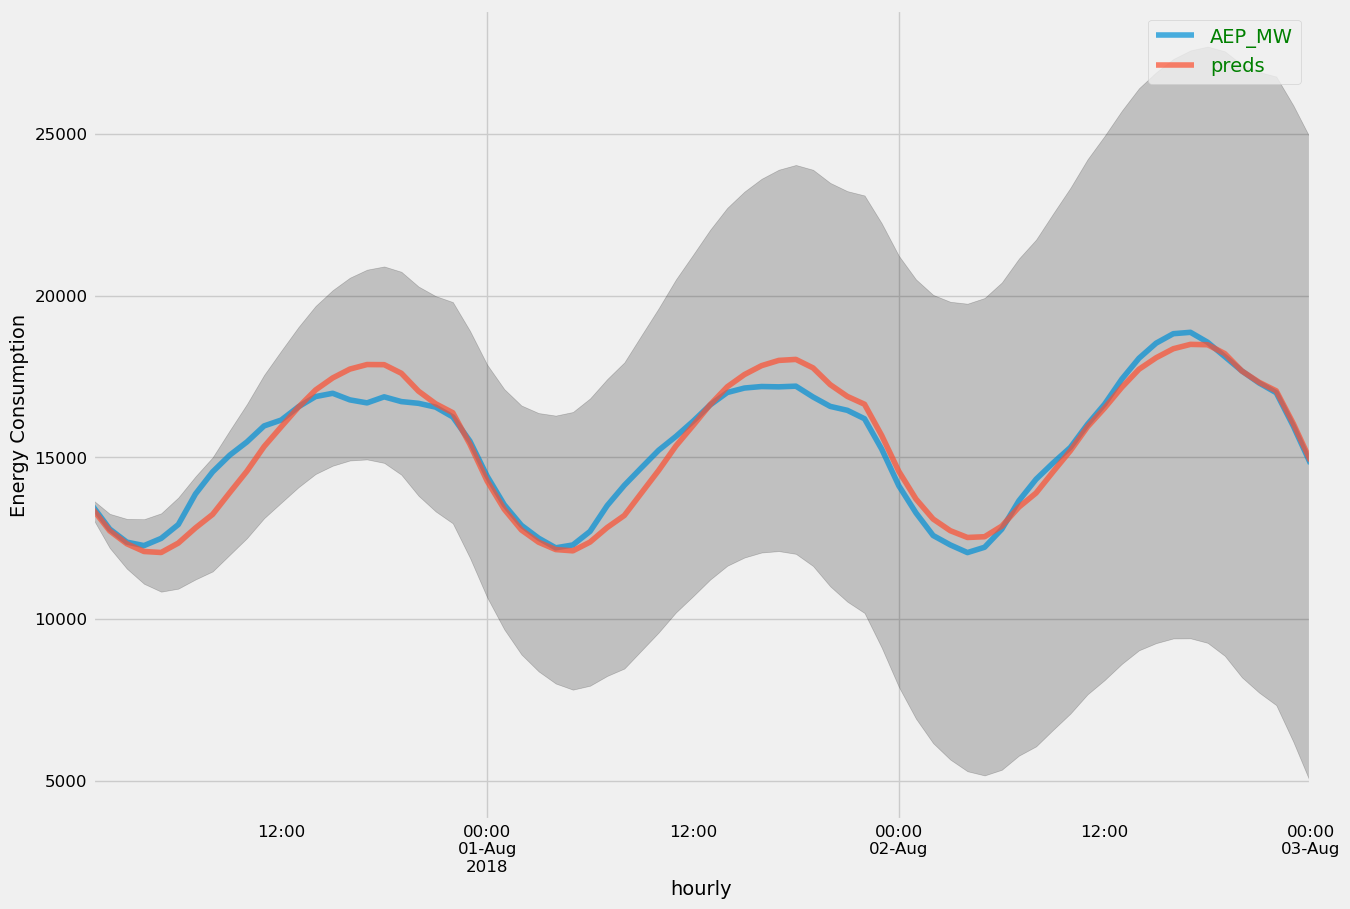

In [26]:
##TimeSeries

ts=hourly_df[-600:].copy()
seasonality=24
freq='H'
ts_test=ts[-72:].copy()
ts_train=ts[:-72].copy()
periods_to_test=ts_test.shape[0]

period='hourly'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]


model_h = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq).fit(disp=False,maxiter=maxiter,)

forecast=model_h.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
predictions=forecast.predicted_mean
ts_test['preds']=predictions
sarimax_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions))
sarimax_nrmse= round(sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",sarimax_nrmse,)

printing_ci()

15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing


NRMSE:  0.19


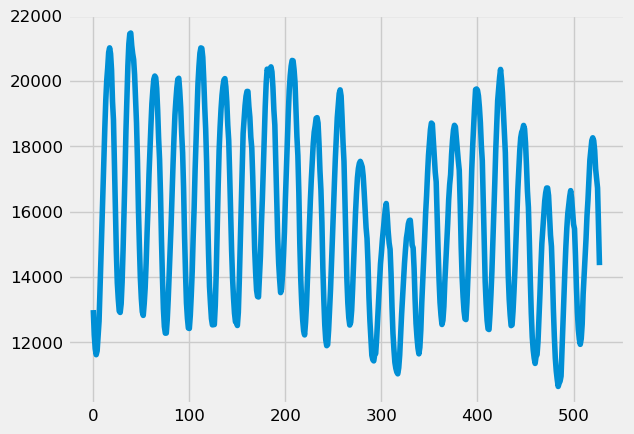

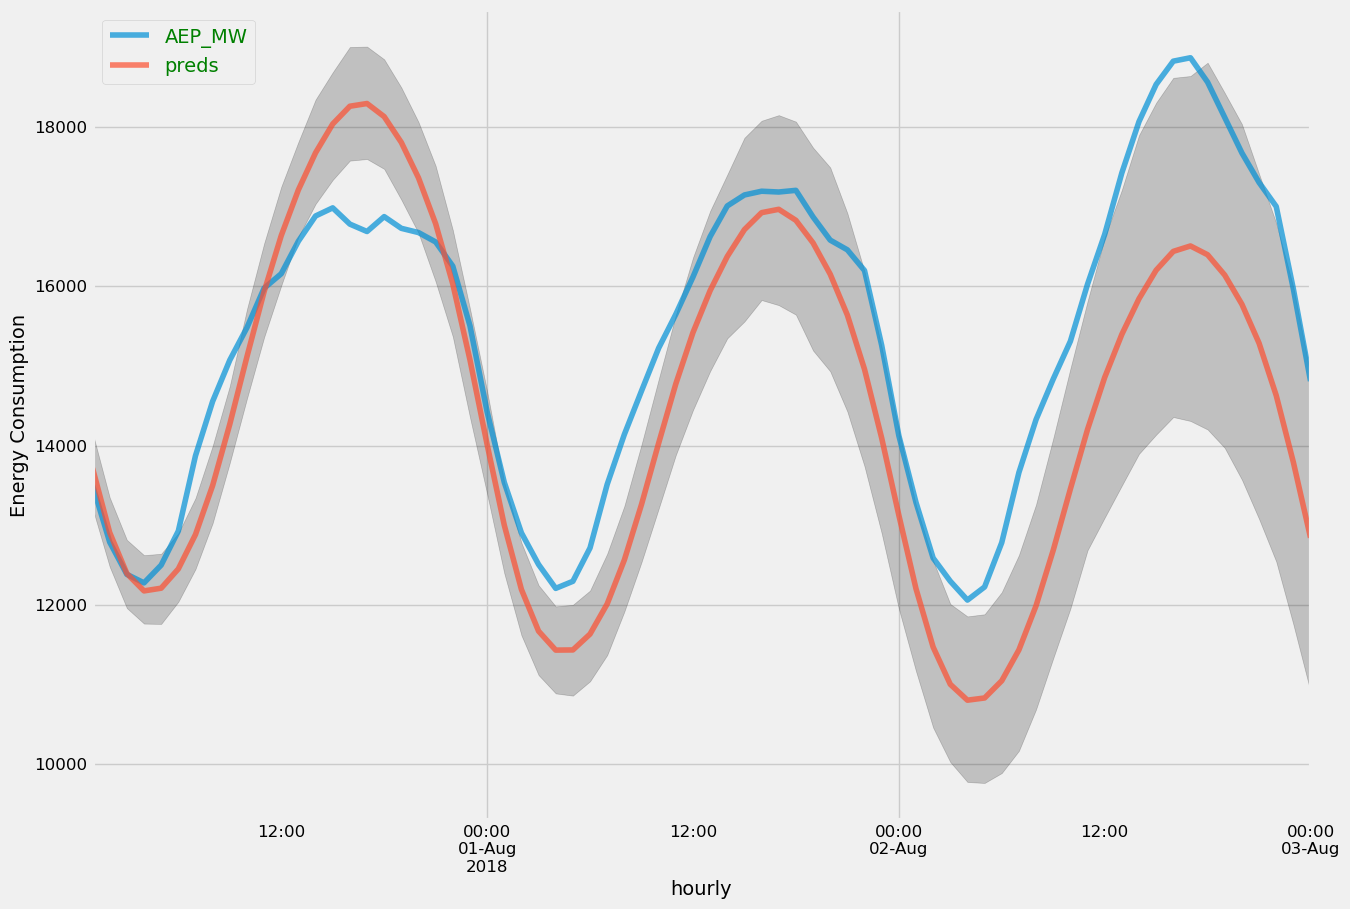

In [27]:
#Prophet
s=hourly_df[-600:].copy()
seasonality=24
freq='H'
ts_test=ts[-72:].copy()
ts_train=ts[:-72].copy()

####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
# ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.preds))
prophet_nrmse=round(prophet_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",prophet_nrmse)
printing_ci()

In [28]:
if round(sarimax_nrmse-prophet_nrmse,2) <0:
    print('Sarimax WINS')
elif round(sarimax_nrmse-prophet_nrmse,2) >0:
    print('Prophet WINS')
else:
    print('It is a tie')
    


Sarimax WINS


We did an analysis over a time series using SARIMA and FBProphet. In all these cases, using the **Normalized Root Mean Squared Error** as a metric, Prophet outscores SARIMA. We might try to dig a little deeper and add some other thoughts and ideas. We are taking about the **conclusions**. Before we do so, I want to prevent us to fall into Recency Bias (thinking that our last case is the one that matters), Confirmation bias (this is what I thought therefore this is it) or, in other words, extend the conclusions of this only case to all other situations and time series we can find in the future.

# **Conclusions**:

1. SARIMA is way slower. It takes more time to train SARIMA and then run the winner. FBrophet has no parameters to tune
2. Prophet scores lower (and better) nrmse most of the times. Sarimax is only better in weekly and hourly. It feels like sarimax does not gain from adding more data points to the dataset. After certain amount of rows, it does not get better rather it worsens
3. SARIMA seems to pick up better the small nuances of the time series like we can see on the weekly analysis. Despite this, Prophet scored better.
